In [15]:
import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

# to suppress warnings of Seaborn's deprecated usage of Matplotlib
import warnings
warnings.filterwarnings("ignore")

<center>
<h1>Handling GPS data with Python</h1>
<img src="./gfx/gnome_maps.png" width=30%>
<h3>Dr. Florian Wilhelm</h3>
<h4>Senior Data Scientist @ <a href="http://www.inovex.de/">inovex</a></h4>
</center>

# Motivation

* Project work and general interest
* Hard to find information about Python libraries
* Interest in the mathematical algorithms of that domain
* Needed a subject for a EuroPython talk ;-)

# GPX: GPS Exchange Format

* common GPS data format
* based on XML schema
* describes waypoints, routes and tracks
* GPS coordinates based GS-84 ellipsoid, height in meters

<img src="./gfx/route_track_mod.png" widht=60%>

# General structure

```xml
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<gpx version="1.1" creator="Creator of the file">
  <metadata> <!-- metadata of the file --> </metadata>
  <wpt lat="xx.xxx" lon="yy.yyy"><!-- ... --></wpt>
  <!-- more waypoints -->
  <rte>
    <!-- attributes of the route -->
    <rtept lat="xx.xxx" lon="yy.yyy"><!-- ... --></rtept>
    <!-- more route points -->
  </rte>
  <!-- more routes -->
  <trk>
    <!-- attributes of the track -->
    <trkseg>
      <trkpt lat="xx.xxx" lon="yy.yyy"><!-- ... --></trkpt>
      <!-- more track points -->
    </trkseg>
    <!-- more track segments -->
  </trk>
  <!-- more tracks -->
</gpx>
```

# Example from Polar Flow
```xml
<?xml version="1.0" encoding="UTF-8"?>
<gpx xmlns="http://www.topografix.com/GPX/1/1" version="1.1" creator="Polar Flow">
  <metadata>
    <author>
      <name>Polar</name>
    </author>
    <time>2016-04-17T08:02:12.000Z</time>
  </metadata>
  <trk>
    <trkseg>
      <trkpt lat="53.560591" lon="9.9755985">
        <ele>17.0</ele>
        <time>2016-04-17T08:02:12.000Z</time>
      </trkpt>
      <trkpt lat="53.560591" lon="9.9755985">
        <ele>17.0</ele>
        <time>2016-04-17T08:02:13.000Z</time>
      </trkpt>
      <!-- ... many more points -->
    </trkseg>
  </trk>
</gpx>
```

# gpxpy: GPX file parser

* for reading and writing GPX files
* licensed unter Apache 2.0
* contains `gpxinfo` cli tool for basic stats
* Python 3 compatible
* written by Tomo Krajina
* used by http://www.trackprofiler.com/

In [2]:
import gpxpy

with open('./gpx/hh_marathon.gpx') as fh:
    gpx_file = gpxpy.parse(fh)

In [16]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([
        {'lat': p.latitude, 
         'lon': p.longitude, 
         'ele': p.elevation,
         'time': p.time} for p in segment.points])
coords.set_index('time', drop=True, inplace=True)
coords.head(3)

,ele,lat,lon
time,,,
2016-04-17 08:02:12,17.0,53.560591,9.975599
2016-04-17 08:02:13,17.0,53.560591,9.975599
2016-04-17 08:02:14,17.0,53.560561,9.975591


# Plotting a track

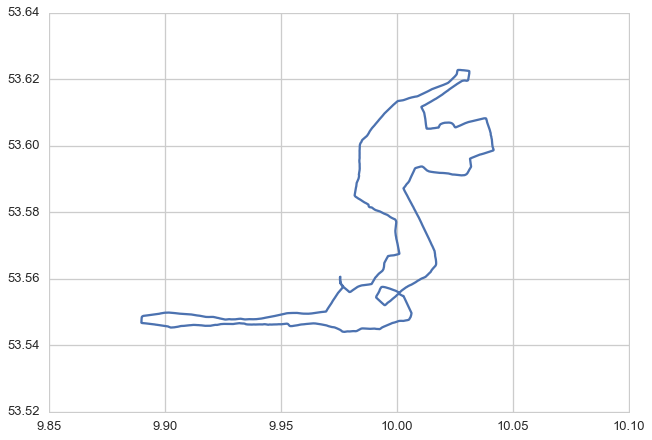

In [18]:
plt.plot(coords['lon'].values, coords['lat'].values)

## ... and the actual GPS coordinates

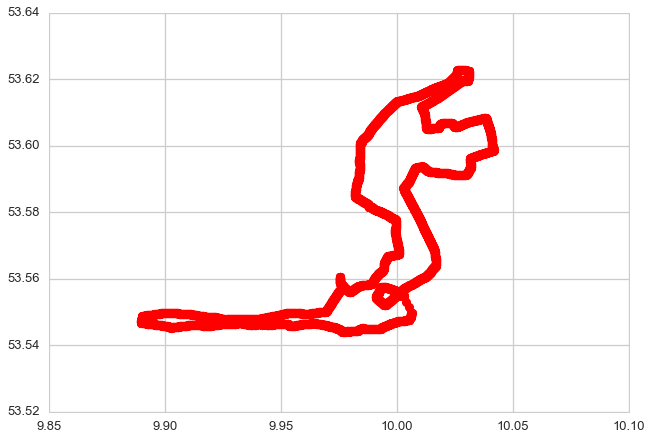

In [26]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.plot(coords['lon'].values, coords['lat'].values, 'ro')

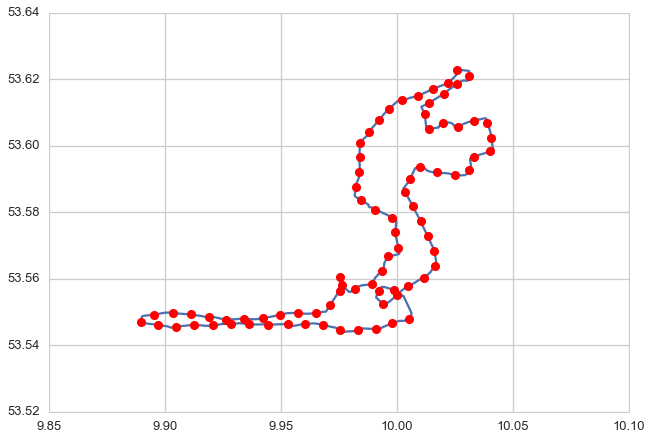

In [23]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.plot(coords['lon'].values[::150], coords['lat'].values[::150], 'ro')

# Simplifying GPS tracks 

Most GPS sensors have a uniform sampling rate leading to overly many points on almost straight lines.

## How can we reduce the number of points?


<center>
    <h1>Ramer-Douglas-Peucker Example</h1>
    <br>
    <img id="example1" src="./gfx/rdp_animation_large.gif" rel:animated_src="./gfx/rdp_animation_large.gif" rel:auto_play="0" width="1024" height="1768" />
    <br>
    <script type="text/javascript">
        var sup1 = requirejs(["js/libgif"], function(SuperGif){
            var sup1 = new SuperGif({ gif: document.getElementById('example1') } );
            sup1.load(function(){
                document.getElementById('button_pause').onmousedown = function(event) {sup1.pause(); return false;};
                document.getElementById('button_play').onmousedown = function(event) {sup1.play(); return false;};
                document.getElementById('button_restart').onmousedown = function(event) {sup1.move_to(0); return false;};
                document.getElementById('button_end').onmousedown = function(event) {sup1.move_to(sup1.get_length()-1); return false;};
                document.getElementById('button_forward').onmousedown = function(event) {sup1.move_relative(1); return false;};
                document.getElementById('button_backword').onmousedown = function(event) {sup1.move_relative(-1); return false;};
            });
            
        
        })
    </script>
    <font size=3>
    <table>
      <tr>
       <td><a href="javascript:;" id="button_play"><i class="fa fa-play" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_pause"><i class="fa fa-pause" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_restart"><i class="fa fa-fast-backward" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_backword"><i class="fa fa-step-backward" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_forward"><i class="fa fa-step-forward" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_end"><i class="fa fa-fast-forward" aria-hidden="true"></i></a></td>
       </tr>
      </table>
     </font>
</center>

In [30]:
# RDP algorithm as long as the rdp package is not iterative. see https://github.com/fhirschmann/rdp/issues/5

from math import sqrt
import numpy as np

def _DouglasPeucker(points, startIndex, lastIndex, epsilon):
    stk = []
    stk.append([startIndex, lastIndex])
    globalStartIndex = startIndex
    bitArray = np.ones(lastIndex-startIndex+1, dtype=bool)

    while len(stk) > 0:
        startIndex = stk[-1][0]
        lastIndex = stk[-1][1]
        stk.pop()

        dmax = 0.
        index = startIndex

        for i in range(index+1, lastIndex):
            if bitArray[i - globalStartIndex]:
                d = PointLineDistance(points[i], points[startIndex], points[lastIndex])
                if d > dmax:
                    index = i
                    dmax = d
        if dmax > epsilon:
            stk.append([startIndex, index])
            stk.append([index, lastIndex])
        else:
            for i in range(startIndex + 1, lastIndex):
                bitArray[i - globalStartIndex] = False
    return bitArray

def rdp(points, epsilon):
    bitArray = _DouglasPeucker(points, 0, len(points)-1, epsilon)
    resList = []
    for i in range(len(points)):
        if bitArray[i]:
            resList.append(points[i])
    return np.array(resList)

def PointLineDistance(point, start, end):
    if np.all(np.equal(start, end)) :
        return np.linalg.norm(point, start)
    n = abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
    d = sqrt((end[0] - start[0]) * (end[0] - start[0]) + (end[1] - start[1]) * (end[1] - start[1]))
    return n/d

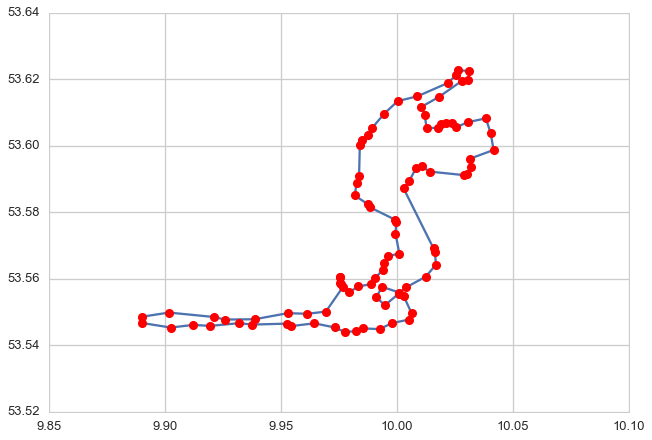

In [40]:
simple_coords = rdp(coords[['lon', 'lat']].values, epsilon=0.0003)
plt.plot(simple_coords[:, 0], simple_coords[:, 1])
plt.plot(simple_coords[:, 0], simple_coords[:, 1], 'ro')

In [42]:
print("{} points reduced to {}!".format(coords.shape[0], simple_coords.shape[0]))

12072 points reduced to 92!


# Kalman Filter and Smoother

* *State equation*: $\mathbf{x}_{k}=\mathbf{F}_{k}\mathbf {x}_{k-1}+\mathbf{B}_{k}\mathbf{u}_{k}+\mathbf{w}_{k}$ where 
  
  - $\mathbf{x}_{k}$ is the state vector at timestep $k$,
  - $\mathbf{u}_{k}$ is the control vector at timestep $k$,
  - $\mathbf{F}_{k}$ is the state transition matrix,
  - $\mathbf{B}_{k}$ is the control-input matrix,
  - $\mathbf{w}_{k}$ is the process noise $\mathbf{w}_{k}\sim{\mathcal{N}}(0,\mathbf{Q}_{k})$ with covariance $\mathbf{Q}_{k}$ 
  

* *Measurement equation*: $\mathbf{z}_{k}=\mathbf{H}_{k}\mathbf{x}_{k}+\mathbf{v}_{k}$ where

  - $\mathbf{z}_{k}$ is the measurement vector at timestep $k$,
  - $\mathbf{H}_{k}$ is the observation matrix,
  - $\mathbf{w}_{k}$ is the observation noise $\mathbf{v}_{k}\sim{\mathcal{N}}(0,\mathbf{R}_{k})$

# ... or much more intuitively put

Let

* $\mathbf{\hat{x}}_{k}^{-}$ be the *a priori*  state estimate with knowledge about the process prior to $k$
* $\mathbf{\hat{x}}_{k}$ be the *a posteriori* state estimate including the the measurement $z_{k}$

and an update equation linking $\mathbf{\hat{x}}_{k}$ to $\mathbf{\hat{x}}_{k}^{-}$, i.e.

$$\mathbf{\hat{x}}_{k} = \mathbf{\hat{x}}_{k}^{-} + \mathbf{K}(\mathbf{\mathbf{z}_{k} - \mathbf{H}\hat{x}}_{k}^{-})$$

where $\mathbf{K}$ is the *Kalman gain*.

**Goal** is to minimize the *a posteriori* estimate error covariance $\mathbf{P}_{k} = \mathbb{E}[\mathbf{e}_k,\mathbf{e}_k]$ with $\mathbf{e}_{k}\equiv\mathbf{x}_{k}-\mathbf{\hat{x}}_{k}$ by finding an optimal $\mathbf{K}$.


<small>[... read <a href="https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf">An Introduction to the Kalman Filter</a> by G. Welch & G. Bishop for more details]</small>

# ... and in practice

<img src="./gfx/prediction_correction.png" width=80%>

## Summary of libraries

* **gpxpy** for reading, writing GPX files as well as imputing of missing values.
* **srtm.py** extends gpxpy to easily add missing elevation data to a GPX file.
* **mplleaflet** converts matplotlib plots into zoomable, pannable, [Leaflet](http://leafletjs.com/) map.
* **rdp** implements the Ramer-Douglas-Peucker algorithm.
* **pykalman** is a dead-simple Kalman Filter, Smoother and EM library.

<center><h1>Questions?</h1><br>
<img src=./gfx/light-bulb.jpg align="center" width=40%/></center>

# Credits

* RDP Example from [Marius Karthaus](http://karthaus.nl/rdp/)
* Waypoint/track graphic adapted from [Wikipedia](https://en.wikipedia.org/wiki/GPS_Exchange_Format)
* Logo on first slide from [Gnome Maps](https://wiki.gnome.org/Apps/Maps)
* Kalman prediction & correction graphic from [Bilgin's blog](http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies)
* Book [Kalman and Bayesian Filters](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) by Roger R. Labbe
